## DRIVE MOUNT & CONFIG


In [ ]:
# Mount Google Drive
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print('Not running in Colab or google.colab unavailable — proceed if dataset path is accessible locally')
    print(e)

# Set dataset root for your layout
DATA_ROOT = '/content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset'  
print('DATA_ROOT =', DATA_ROOT)


Mounted at /content/drive
DATA_ROOT = /content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset


# Model-2: Deep Forensic Check - Deepfake & Morphed Image Detection

This notebook implements a **multi-stream deep learning model** for detecting manipulated images (morphing, splicing, deepfakes) with **tamper localization**.

## Features
- **Multi-stream Architecture**: RGB + High-pass + DCT frequency features
- **Dual Outputs**: Binary classification (real/fake) + Localization heatmap
- **Comprehensive Evaluation**: Accuracy, ROC-AUC, F1, Recall, Precision
- **Model Download**: Save trained weights for deployment
- **Testing Interface**: Upload images for real-time classification

## Dataset Structure


## 1 Environment Setup & Dependencies

Installing required packages for Model-2 training and evaluation.

In [3]:
# Environment setup (safe to re-run)
import sys, os, subprocess, importlib

REQS = [
    'torch', 'torchvision', 'torchaudio',
    'timm', 'albumentations', 'opencv-python', 'numpy', 'scikit-learn',
    'tensorboard'
]

def ensure_installed(pkgs):
    for pkg in pkgs:
        try:
            importlib.import_module(pkg.split('==')[0].split('>=')[0])
        except ImportError:
            print(f'Installing {pkg}...')
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

ensure_installed(REQS)

# Detect Colab and optionally mount Google Drive
IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive  # type: ignore
    def mount_drive(path='/content/drive'):
        drive.mount(path)
        return path
else:
    def mount_drive(path=None):
        print('Running outside Colab; Google Drive mounting skipped.')
        return None

print('Colab:', IN_COLAB)



Installing opencv-python...
Installing scikit-learn...
Colab: True


## 2 Configuration Settings

Define all hyperparameters and paths for training:
- **Data paths**: Location of train/val/test datasets
- **Model settings**: Backbone architecture, image size, batch size
- **Training params**: Learning rate, epochs, optimizer settings
- **Output paths**: Where to save models and results

In [ ]:
# Configuration
from dataclasses import dataclass

@dataclass
class Config:
    # Data
    data_dir: str = '/content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset'  
    img_size: int = 160
    use_srm: bool = True
    num_workers: int = 2
    batch_size: int = 32

    # Model
    model_variant: str = 'full'  # 'full' or 'lite'
    backbone: str = 'tf_efficientnet_b0_ns'
    shared_backbone: bool = True
    decoder: str = 'fpn'  # 'simple'|'unet'|'fpn'
    use_cbam: bool = True

    # Train
    epochs: int = 50
    lr: float = 1e-4
    lr_min: float = 1e-6
    weight_decay: float = 1e-4
    optimizer: str = 'adamw'  # 'adamw'|'sgd'
    scheduler: str = 'cosine'  # 'cosine'|'step'|'none'
    mixed_precision: bool = True
    early_stopping: int = 20

    # Loss
    loss_alpha: float = 0.7
    loss_beta: float = 0.3
    use_focal: bool = True  # improve F1 on imbalance

    # Augment
    use_mixup: bool = True
    use_cutmix: bool = True

    # Misc
    seed: int = 42
    output_dir: str = './outputs'

CFG = Config()

# Optional: mount Google Drive and point data_dir
if IN_COLAB:
    mount_drive()
    CFG.data_dir = '/content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset'

print('Configured data_dir:', CFG.data_dir)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Configured data_dir: /content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset


## 3 Mount Google Drive

Connect to Google Drive to access the `Model2_Dataset` folder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

CFG.data_dir = '/content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset' 
print(f"Dataset directory: {CFG.data_dir}")
print(f"Train dir exists: {os.path.exists(os.path.join(CFG.data_dir, 'train'))}")
print(f"Validation dir exists: {os.path.exists(os.path.join(CFG.data_dir, 'validation'))}")
print(f"Test dir exists: {os.path.exists(os.path.join(CFG.data_dir, 'test'))}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dataset directory: /content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset
Train dir exists: True
Validation dir exists: True
Test dir exists: True


## 4️ Preprocessing Utilities

Multi-stream preprocessing functions:
- **High-pass filtering**: Detects edges and artifacts using Laplacian/Sobel
- **SRM filters**: Spatial Rich Model for manipulation detection
- **DCT features**: Frequency domain analysis for JPEG artifacts
- **JPEG compression**: Augmentation for robustness

In [6]:
# Preprocessing utilities (high-pass, SRM, DCT, JPEG, etc.)
import cv2
import numpy as np
import torch


def high_pass_filter(img, method='laplacian'):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    if method == 'laplacian':
        hp = cv2.Laplacian(gray, cv2.CV_64F)
        hp = np.abs(hp)
        hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    elif method == 'sobel':
        sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        hp = np.sqrt(sobel_x**2 + sobel_y**2)
        hp = cv2.normalize(hp, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    elif method == 'canny':
        hp = cv2.Canny(gray, 100, 200)
    else:
        raise ValueError(f"Unknown high-pass method: {method}")
    hp_rgb = cv2.merge([hp, hp, hp])
    return hp_rgb


def srm_filter(img):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    kernels = [
        np.array([[-1, 2, -1],[2, -4, 2],[-1, 2, -1]]) / 4.0,
        np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) / 4.0,
        np.array([[1, 0, -1],[0, 0, 0],[-1, 0, 1]]) / 2.0,
    ]
    filtered_responses = []
    for kernel in kernels:
        response = cv2.filter2D(gray.astype(np.float32), -1, kernel)
        filtered_responses.append(np.abs(response))
    srm = np.max(filtered_responses, axis=0)
    srm = cv2.normalize(srm, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    srm_rgb = cv2.merge([srm, srm, srm])
    return srm_rgb


def dct_features(img, block_size=8, resize_to=None):
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    h, w = gray.shape
    new_h = (h // block_size) * block_size
    new_w = (w // block_size) * block_size
    gray_resized = cv2.resize(gray, (new_w, new_h))
    dct_output = np.zeros_like(gray_resized, dtype=np.float32)
    for i in range(0, new_h, block_size):
        for j in range(0, new_w, block_size):
            block = gray_resized[i:i+block_size, j:j+block_size].astype(np.float32)
            dct_block = cv2.dct(block)
            dct_output[i:i+block_size, j:j+block_size] = np.abs(dct_block)
    dct_output = cv2.normalize(dct_output, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    if resize_to is not None:
        dct_output = cv2.resize(dct_output, resize_to)
    elif (new_h, new_w) != (h, w):
        dct_output = cv2.resize(dct_output, (w, h))
    dct_rgb = cv2.merge([dct_output, dct_output, dct_output])
    return dct_rgb


def jpeg_compress(img, quality=75):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encoded = cv2.imencode('.jpg', img, encode_param)
    compressed = cv2.imdecode(encoded, cv2.IMREAD_COLOR)
    return compressed



## 5 Data Augmentation Pipeline

Advanced augmentation techniques:
- **Geometric**: Rotation, flipping, cropping, resizing
- **Color**: Brightness, contrast, saturation, hue shifts
- **Noise**: Gaussian noise, JPEG compression artifacts
- **MixUp & CutMix**: Advanced mixing strategies for better generalization

In [7]:
# Augmentations, MixUp, CutMix
import albumentations as A
from albumentations.pytorch import ToTensorV2


def get_train_augmentation(img_size=256):
    return A.Compose([
        A.ImageCompression(quality_range=(50, 95), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=10, p=0.3),
        A.RandomResizedCrop(size=(img_size, img_size), scale=(0.8, 1.0), p=0.5),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),
        A.Downscale(scale_min=0.5, scale_max=0.9, p=0.2),
        A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), p=0.2),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


def get_val_augmentation(img_size=256):
    return A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])


class MixUp:
    def __init__(self, alpha=0.2, prob=0.5):
        self.alpha = alpha
        self.prob = prob
    def __call__(self, batch):
        if np.random.rand() > self.prob:
            return batch
        rgb, hp, dct, labels, masks = batch
        b = rgb.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(b)
        mixed_rgb = lam * rgb + (1 - lam) * rgb[index]
        mixed_hp = lam * hp + (1 - lam) * hp[index]
        mixed_dct = lam * dct + (1 - lam) * dct[index]
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        mixed_masks = lam * masks + (1 - lam) * masks[index]
        return mixed_rgb, mixed_hp, mixed_dct, mixed_labels, mixed_masks


class CutMix:
    def __init__(self, alpha=1.0, prob=0.5):
        self.alpha = alpha
        self.prob = prob
    def __call__(self, batch):
        if np.random.rand() > self.prob:
            return batch
        rgb, hp, dct, labels, masks = batch
        b = rgb.size(0)
        lam = np.random.beta(self.alpha, self.alpha)
        index = torch.randperm(b)
        _, _, H, W = rgb.shape
        cut_ratio = np.sqrt(1.0 - lam)
        cut_h = int(H * cut_ratio)
        cut_w = int(W * cut_ratio)
        cx = np.random.randint(W)
        cy = np.random.randint(H)
        x1 = np.clip(cx - cut_w // 2, 0, W)
        y1 = np.clip(cy - cut_h // 2, 0, H)
        x2 = np.clip(cx + cut_w // 2, 0, W)
        y2 = np.clip(cy + cut_h // 2, 0, H)
        mixed_rgb = rgb.clone(); mixed_hp = hp.clone(); mixed_dct = dct.clone(); mixed_masks = masks.clone()
        mixed_rgb[:, :, y1:y2, x1:x2] = rgb[index, :, y1:y2, x1:x2]
        mixed_hp[:, :, y1:y2, x1:x2] = hp[index, :, y1:y2, x1:x2]
        mixed_dct[:, :, y1:y2, x1:x2] = dct[index, :, y1:y2, x1:x2]
        mixed_masks[:, :, y1:y2, x1:x2] = masks[index, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        mixed_labels = lam * labels + (1 - lam) * labels[index]
        return mixed_rgb, mixed_hp, mixed_dct, mixed_labels, mixed_masks

## 6 Dataset & DataLoaders

Multi-stream dataset loader:
- Loads RGB images from train/validation/test folders
- Generates high-pass and DCT streams on-the-fly
- Applies augmentations consistently across all streams
- Creates PyTorch DataLoaders with proper batching

In [8]:
# Dataset and DataLoaders (Multi-stream)
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader


class MultiStreamDataset(Dataset):
    def __init__(self, image_paths, labels, mask_paths=None, transform=None, img_size=256, hp_method='laplacian', use_srm=False):
        self.image_paths = image_paths
        self.labels = labels
        self.mask_paths = mask_paths
        self.transform = transform
        self.img_size = img_size
        self.hp_method = hp_method
        self.use_srm = use_srm
        assert len(image_paths) == len(labels), 'Mismatch between images and labels'
        if mask_paths is not None:
            assert len(image_paths) == len(mask_paths), 'Mismatch between images and masks'
    def __len__(self):
        return len(self.image_paths)
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            img = cv2.imread(img_path)
            if img is None:
                raise ValueError(f'Failed to load image: {img_path}')
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f'Error loading image {img_path}: {e}')
            img = np.zeros((self.img_size, self.img_size, 3), dtype=np.uint8)
        img = cv2.resize(img, (self.img_size, self.img_size))
        has_mask = False
        if self.mask_paths is not None and self.mask_paths[idx] is not None:
            try:
                mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
                if mask is not None:
                    mask = cv2.resize(mask, (self.img_size, self.img_size))
                    mask = (mask > 127).astype(np.float32)
                    has_mask = True
                else:
                    mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
            except Exception as e:
                print(f'Error loading mask {self.mask_paths[idx]}: {e}')
                mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        else:
            mask = np.zeros((self.img_size, self.img_size), dtype=np.float32)
        label = float(self.labels[idx])
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            rgb = transformed['image']
            mask = transformed['mask']
        else:
            rgb = img.astype(np.float32) / 255.0
            rgb = torch.from_numpy(rgb.transpose(2, 0, 1))
        hp_img = srm_filter(img) if self.use_srm else high_pass_filter(img, method=self.hp_method)
        if self.transform is not None:
            hp = self.transform(image=hp_img)['image']
        else:
            hp = hp_img.astype(np.float32) / 255.0
            hp = torch.from_numpy(hp.transpose(2, 0, 1))
        dct_img = dct_features(img, resize_to=(self.img_size, self.img_size))
        if self.transform is not None:
            dct = self.transform(image=dct_img)['image']
        else:
            dct = dct_img.astype(np.float32) / 255.0
            dct = torch.from_numpy(dct.transpose(2, 0, 1))
        if isinstance(mask, np.ndarray):
            mask = torch.from_numpy(mask).unsqueeze(0).float()
        elif len(mask.shape) == 2:
            mask = mask.unsqueeze(0)
        return rgb, hp, dct, torch.tensor([label], dtype=torch.float32), mask, has_mask


class ForensicDataset(Dataset):
    def __init__(self, data_dir, split='train', transform=None, img_size=256, hp_method='laplacian', use_srm=False):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        self.hp_method = hp_method
        self.use_srm = use_srm
        self.image_paths, self.labels, self.mask_paths = [], [], []
        real_dir = os.path.join(data_dir, split, 'real')
        if os.path.exists(real_dir):
            for img_name in os.listdir(real_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    self.image_paths.append(os.path.join(real_dir, img_name))
                    self.labels.append(0)
                    self.mask_paths.append(None)
        fake_dir = os.path.join(data_dir, split, 'fake')
        if os.path.exists(fake_dir):
            masks_dir = os.path.join(data_dir, split, 'masks')
            has_masks_dir = os.path.exists(masks_dir)
            for img_name in os.listdir(fake_dir):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                    self.image_paths.append(os.path.join(fake_dir, img_name))
                    self.labels.append(1)
                    if has_masks_dir:
                        mask_name = os.path.splitext(img_name)[0] + '.png'
                        mask_path = os.path.join(masks_dir, mask_name)
                        self.mask_paths.append(mask_path if os.path.exists(mask_path) else None)
                    else:
                        self.mask_paths.append(None)
        print(f'Loaded {len(self.image_paths)} images for {split} split')
        print(f'  Real: {sum(1 for l in self.labels if l == 0)}')
        print(f'  Fake: {sum(1 for l in self.labels if l == 1)}')
        print(f'  With masks: {sum(1 for m in self.mask_paths if m is not None)}')
        self.dataset = MultiStreamDataset(self.image_paths, self.labels, self.mask_paths, transform, img_size, hp_method, use_srm)
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, idx):
        return self.dataset[idx]


def collate_fn(batch):
    rgb_list, hp_list, dct_list, label_list, mask_list, has_mask_list = zip(*batch)
    rgb = torch.stack(rgb_list)
    hp = torch.stack(hp_list)
    dct = torch.stack(dct_list)
    labels = torch.stack(label_list)
    masks = torch.stack(mask_list)
    has_mask = torch.tensor(has_mask_list, dtype=torch.bool)
    return rgb, hp, dct, labels, masks, has_mask


def create_dataloaders(data_dir, batch_size=8, num_workers=2, img_size=256, use_srm=False):
    train_dataset = ForensicDataset(data_dir, split='train', transform=get_train_augmentation(img_size), img_size=img_size, use_srm=use_srm)
    val_dataset = ForensicDataset(data_dir, split='validation', transform=get_val_augmentation(img_size), img_size=img_size, use_srm=use_srm)
    test_dataset = ForensicDataset(data_dir, split='test', transform=get_val_augmentation(img_size), img_size=img_size, use_srm=use_srm)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, collate_fn=collate_fn, pin_memory=True)
    return train_loader, val_loader, test_loader



## 7 Loss Functions & Evaluation Metrics

**Loss Functions:**
- **Binary Cross Entropy**: For classification (real vs fake)
- **Dice Loss**: For localization (if masks available)
- **Combo Loss**: Weighted combination of BCE + Dice

**Evaluation Metrics:**
- Accuracy, Precision, Recall, F1-Score
- ROC-AUC, PR-AUC
- Confusion Matrix
- Per-class metrics

In [9]:
# Losses and Metrics
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix
)


class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    def forward(self, pred, target):
        pred = pred.contiguous().view(-1)
        target = target.contiguous().view(-1)
        intersection = (pred * target).sum()
        dice_coeff = (2. * intersection + self.smooth) / (pred.sum() + target.sum() + self.smooth)
        return 1 - dice_coeff


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
    def forward(self, pred, target):
        bce_loss = F.binary_cross_entropy_with_logits(pred, target, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal_loss.mean()


class ComboLoss(nn.Module):
    def __init__(self, alpha=0.7, beta=0.3, use_focal=False, smooth=1.0):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.cls_loss = FocalLoss() if use_focal else nn.BCEWithLogitsLoss()
        self.loc_loss = DiceLoss(smooth=smooth)
    def forward(self, cls_pred, cls_target, mask_pred, mask_target, has_mask=None):
        loss_cls = self.cls_loss(cls_pred, cls_target)
        if has_mask is not None:
            mask_indices = has_mask.bool()
            if mask_indices.sum() > 0:
                loss_loc = self.loc_loss(mask_pred[mask_indices], mask_target[mask_indices])
            else:
                loss_loc = torch.tensor(0.0, device=cls_pred.device)
        else:
            loss_loc = self.loc_loss(mask_pred, mask_target)
        total_loss = self.alpha * loss_cls + self.beta * loss_loc
        return total_loss, loss_cls, loss_loc


def calculate_dice(pred, target, threshold=0.5, smooth=1.0):
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.detach().cpu().numpy()
    pred_binary = (pred > threshold).astype(np.float32)
    target_binary = (target > threshold).astype(np.float32)
    pred_flat = pred_binary.flatten(); target_flat = target_binary.flatten()
    intersection = (pred_flat * target_flat).sum()
    dice = (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)
    return dice


def calculate_iou(pred, target, threshold=0.5, smooth=1.0):
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.detach().cpu().numpy()
    pred_binary = (pred > threshold).astype(np.float32)
    target_binary = (target > threshold).astype(np.float32)
    pred_flat = pred_binary.flatten(); target_flat = target_binary.flatten()
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


def calculate_pixel_accuracy(pred, target, threshold=0.5):
    if isinstance(pred, torch.Tensor):
        pred = pred.detach().cpu().numpy()
    if isinstance(target, torch.Tensor):
        target = target.detach().cpu().numpy()
    pred_binary = (pred > threshold).astype(np.float32)
    target_binary = (target > threshold).astype(np.float32)
    correct = (pred_binary == target_binary).sum(); total = pred_binary.size
    return correct / total


class ForensicMetrics:
    def __init__(self):
        self.reset()
    def reset(self):
        self.cls_preds = []
        self.cls_targets = []
        self.cls_probs = []
        self.mask_preds = []
        self.mask_targets = []
        self.technique_preds = {}
        self.technique_targets = {}
    def update(self, cls_pred, cls_target, mask_pred=None, mask_target=None, technique=None):
        if isinstance(cls_pred, torch.Tensor):
            cls_pred = cls_pred.detach().cpu().numpy()
        if isinstance(cls_target, torch.Tensor):
            cls_target = cls_target.detach().cpu().numpy()
        self.cls_preds.extend(cls_pred.flatten())
        self.cls_targets.extend(cls_target.flatten())
        if cls_pred.max() > 1.0 or cls_pred.min() < 0.0:
            cls_probs = 1 / (1 + np.exp(-cls_pred))
        else:
            cls_probs = cls_pred
        self.cls_probs.extend(cls_probs.flatten())
        if mask_pred is not None and mask_target is not None:
            if isinstance(mask_pred, torch.Tensor):
                mask_pred = mask_pred.detach().cpu().numpy()
            if isinstance(mask_target, torch.Tensor):
                mask_target = mask_target.detach().cpu().numpy()
            self.mask_preds.append(mask_pred)
            self.mask_targets.append(mask_target)
        if technique is not None:
            if technique not in self.technique_preds:
                self.technique_preds[technique] = []
                self.technique_targets[technique] = []
            self.technique_preds[technique].extend(cls_probs.flatten())
            self.technique_targets[technique].extend(cls_target.flatten())
    def compute_classification_metrics(self, threshold=0.5):
        probs = np.array(self.cls_probs)
        targets = np.array(self.cls_targets)
        preds = (probs > threshold).astype(int)
        metrics = {
            'accuracy': accuracy_score(targets, preds),
            'precision': precision_score(targets, preds, zero_division=0),
            'recall': recall_score(targets, preds, zero_division=0),
            'f1': f1_score(targets, preds, zero_division=0),
            'roc_auc': roc_auc_score(targets, probs) if len(np.unique(targets)) > 1 else 0.0,
            'pr_auc': average_precision_score(targets, probs) if len(np.unique(targets)) > 1 else 0.0,
        }
        cm = confusion_matrix(targets, preds)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            metrics['true_negatives'] = int(tn)
            metrics['false_positives'] = int(fp)
            metrics['false_negatives'] = int(fn)
            metrics['true_positives'] = int(tp)
            metrics['specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        return metrics
    def compute_localization_metrics(self, threshold=0.5):
        if not self.mask_preds or not self.mask_targets:
            return {}
        all_preds = np.concatenate([m.flatten() for m in self.mask_preds])
        all_targets = np.concatenate([m.flatten() for m in self.mask_targets])
        metrics = {
            'dice': calculate_dice(all_preds, all_targets, threshold),
            'iou': calculate_iou(all_preds, all_targets, threshold),
            'pixel_accuracy': calculate_pixel_accuracy(all_preds, all_targets, threshold),
        }
        return metrics
    def compute_per_technique_metrics(self, threshold=0.5):
        per_technique = {}
        for technique in self.technique_preds.keys():
            probs = np.array(self.technique_preds[technique])
            targets = np.array(self.technique_targets[technique])
            preds = (probs > threshold).astype(int)
            per_technique[technique] = {
                'accuracy': accuracy_score(targets, preds),
                'precision': precision_score(targets, preds, zero_division=0),
                'recall': recall_score(targets, preds, zero_division=0),
                'f1': f1_score(targets, preds, zero_division=0),
                'count': len(targets),
            }
        return per_technique
    def compute_all_metrics(self, threshold=0.5):
        return {
            'classification': self.compute_classification_metrics(threshold),
            'localization': self.compute_localization_metrics(threshold),
            'per_technique': self.compute_per_technique_metrics(threshold),
        }


def optimize_f1_threshold(probs, targets, search=np.linspace(0.2, 0.8, 61)):
    probs = np.array(probs).flatten(); targets = np.array(targets).flatten().astype(int)
    best_t, best_f1 = 0.5, -1.0
    for t in search:
        preds = (probs > t).astype(int)
        f1 = f1_score(targets, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1; best_t = float(t)
    return best_t, best_f1



## 8 Model Architecture Components

**Backbone Networks:**
- EfficientNet-B0/B2/B4 (lightweight to heavy)
- Xception (specialized for deepfake detection)
- Shared or separate backbones for each stream

**Fusion Mechanisms:**
- CBAM (Convolutional Block Attention Module)
- Transformer-based fusion
- Feature Pyramid Network (FPN)

**Decoders:**
- Simple upsampling decoder
- U-Net style with skip connections
- FPN decoder for multi-scale features

In [10]:
# Backbones, Fusion, and Decoder modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from timm import create_model


def create_backbone(backbone_name='tf_efficientnet_b2_ns', pretrained=True, features_only=True):
    if features_only:
        model = create_model(backbone_name, pretrained=pretrained, features_only=True, out_indices=(1, 2, 3, 4))
    else:
        model = create_model(backbone_name, pretrained=pretrained, num_classes=0, global_pool='avg')
    return model


class SharedBackbone(nn.Module):
    def __init__(self, backbone_name='tf_efficientnet_b2_ns', pretrained=True):
        super().__init__()
        self.backbone = create_backbone(backbone_name, pretrained, features_only=True)
        with torch.no_grad():
            dummy = torch.randn(1, 3, 256, 256)
            features = self.backbone(dummy)
            self.feature_dims = [f.shape[1] for f in features]
    def forward(self, rgb, hp, dct):
        rgb_features = self.backbone(rgb)
        hp_features = self.backbone(hp)
        dct_features = self.backbone(dct)
        return rgb_features, hp_features, dct_features


class MultiBackbone(nn.Module):
    def __init__(self, backbone_name='tf_efficientnet_b2_ns', pretrained=True):
        super().__init__()
        self.rgb_backbone = create_backbone(backbone_name, pretrained, features_only=True)
        self.hp_backbone = create_backbone(backbone_name, pretrained, features_only=True)
        self.dct_backbone = create_backbone(backbone_name, pretrained, features_only=True)
        with torch.no_grad():
            dummy = torch.randn(1, 3, 256, 256)
            features = self.rgb_backbone(dummy)
            self.feature_dims = [f.shape[1] for f in features]
    def forward(self, rgb, hp, dct):
        return self.rgb_backbone(rgb), self.hp_backbone(hp), self.dct_backbone(dct)


class CBAM(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(channels, channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(channels // reduction, channels, 1, bias=False)
        )
        self.conv = nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x)); max_out = self.fc(self.max_pool(x))
        x = x * self.sigmoid(avg_out + max_out)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = x * self.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        return x


class MultiStreamFusion(nn.Module):
    def __init__(self, channels, use_cbam=True):
        super().__init__()
        self.use_cbam = use_cbam
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(channels * 3, channels, 1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True)
        )
        if use_cbam:
            self.cbam = CBAM(channels)
    def forward(self, rgb_feat, hp_feat, dct_feat):
        fused = torch.cat([rgb_feat, hp_feat, dct_feat], dim=1)
        fused = self.fusion_conv(fused)
        if self.use_cbam:
            fused = self.cbam(fused)
        return fused


class LocalizationDecoder(nn.Module):
    def __init__(self, in_channels, out_size=256):
        super().__init__()
        self.out_size = out_size
        self.up1 = nn.Sequential(nn.ConvTranspose2d(in_channels, 512, 4, 2, 1), nn.BatchNorm2d(512), nn.ReLU(inplace=True))
        self.up2 = nn.Sequential(nn.ConvTranspose2d(512, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.up3 = nn.Sequential(nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.ReLU(inplace=True))
        self.up4 = nn.Sequential(nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.BatchNorm2d(64), nn.ReLU(inplace=True))
        self.final = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())
    def forward(self, x):
        x = self.up1(x); x = self.up2(x); x = self.up3(x); x = self.up4(x)
        heatmap = self.final(x)
        if heatmap.shape[2] != self.out_size or heatmap.shape[3] != self.out_size:
            heatmap = F.interpolate(heatmap, size=(self.out_size, self.out_size), mode='bilinear', align_corners=False)
        return heatmap


class UNetDecoder(nn.Module):
    def __init__(self, encoder_channels, out_size=256):
        super().__init__()
        self.out_size = out_size
        self.up4 = self._block(encoder_channels[3], encoder_channels[2])
        self.up3 = self._block(encoder_channels[2] * 2, encoder_channels[1])
        self.up2 = self._block(encoder_channels[1] * 2, encoder_channels[0])
        self.up1 = self._block(encoder_channels[0] * 2, 64)
        self.final = nn.Sequential(nn.Conv2d(64, 1, 1), nn.Sigmoid())
    def _block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 4, 2, 1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1), nn.BatchNorm2d(out_ch), nn.ReLU(inplace=True)
        )
    def forward(self, feats):
        x = self.up4(feats[3])
        x = torch.cat([x, feats[2]], dim=1); x = self.up3(x)
        x = torch.cat([x, feats[1]], dim=1); x = self.up2(x)
        x = torch.cat([x, feats[0]], dim=1); x = self.up1(x)
        heatmap = self.final(x)
        if heatmap.shape[2] != self.out_size or heatmap.shape[3] != self.out_size:
            heatmap = F.interpolate(heatmap, size=(self.out_size, self.out_size), mode='bilinear', align_corners=False)
        return heatmap


class FPNDecoder(nn.Module):
    def __init__(self, encoder_channels, fpn_channels=256, out_size=256):
        super().__init__()
        self.out_size = out_size
        self.lateral4 = nn.Conv2d(encoder_channels[3], fpn_channels, 1)
        self.lateral3 = nn.Conv2d(encoder_channels[2], fpn_channels, 1)
        self.lateral2 = nn.Conv2d(encoder_channels[1], fpn_channels, 1)
        self.lateral1 = nn.Conv2d(encoder_channels[0], fpn_channels, 1)
        self.smooth4 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.smooth3 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.smooth2 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.smooth1 = nn.Conv2d(fpn_channels, fpn_channels, 3, padding=1)
        self.head = nn.Sequential(nn.Conv2d(fpn_channels, 128, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(128, 64, 3, padding=1), nn.ReLU(inplace=True), nn.Conv2d(64, 1, 1), nn.Sigmoid())
    def forward(self, feats):
        p4 = self.lateral4(feats[3]); p3 = self.lateral3(feats[2]); p2 = self.lateral2(feats[1]); p1 = self.lateral1(feats[0])
        p3 = p3 + F.interpolate(p4, size=p3.shape[2:], mode='nearest')
        p2 = p2 + F.interpolate(p3, size=p2.shape[2:], mode='nearest')
        p1 = p1 + F.interpolate(p2, size=p1.shape[2:], mode='nearest')
        p4 = self.smooth4(p4); p3 = self.smooth3(p3); p2 = self.smooth2(p2); p1 = self.smooth1(p1)
        heatmap = self.head(p1)
        if heatmap.shape[2] != self.out_size or heatmap.shape[3] != self.out_size:
            heatmap = F.interpolate(heatmap, size=(self.out_size, self.out_size), mode='bilinear', align_corners=False)
        return heatmap



## 9 DeepForensicNet - Main Model

Complete multi-stream model with:
- **Input**: RGB image (256×256 or 299×299)
- **Streams**: RGB + High-pass + DCT features
- **Fusion**: CBAM attention mechanism
- **Outputs**:
  - Classification head → sigmoid (real/fake probability)
  - Localization head → heatmap (tamper regions)

In [11]:
# DeepForensicNet models
class DeepForensicNet(nn.Module):
    def __init__(self, backbone_name='tf_efficientnet_b2_ns', shared_backbone=True, decoder_type='fpn', use_cbam=True, img_size=256, pretrained=True):
        super().__init__()
        self.img_size = img_size
        self.decoder_type = decoder_type
        self.backbone = SharedBackbone(backbone_name, pretrained) if shared_backbone else MultiBackbone(backbone_name, pretrained)
        feature_dims = self.backbone.feature_dims
        self.fusion_modules = nn.ModuleList([MultiStreamFusion(dim, use_cbam=use_cbam) for dim in feature_dims])
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3), nn.Linear(feature_dims[-1], 512), nn.ReLU(inplace=True),
            nn.Dropout(0.2), nn.Linear(512, 256), nn.ReLU(inplace=True), nn.Linear(256, 1)
        )
        if decoder_type == 'simple':
            self.decoder = LocalizationDecoder(feature_dims[-1], out_size=img_size)
        elif decoder_type == 'unet':
            self.decoder = UNetDecoder(feature_dims, out_size=img_size)
        elif decoder_type == 'fpn':
            self.decoder = FPNDecoder(feature_dims, out_size=img_size)
        else:
            raise ValueError(f'Unknown decoder type: {decoder_type}')
    def forward(self, rgb, hp, dct):
        rgb_features, hp_features, dct_features = self.backbone(rgb, hp, dct)
        fused_features = []
        for i, fusion in enumerate(self.fusion_modules):
            fused_features.append(fusion(rgb_features[i], hp_features[i], dct_features[i]))
        cls_features = self.global_pool(fused_features[-1]).view(rgb.size(0), -1)
        cls_logits = self.classifier(cls_features)
        heatmap = self.decoder(fused_features if self.decoder_type != 'simple' else fused_features[-1])
        return cls_logits, heatmap
    def predict(self, rgb, hp, dct, threshold=0.5):
        self.eval()
        with torch.no_grad():
            cls_logits, heatmap = self.forward(rgb, hp, dct)
            probability = torch.sigmoid(cls_logits).item()
            label = 'fake' if probability > threshold else 'real'
            confidence = abs(probability - threshold)
            return {'probability': probability, 'label': label, 'confidence': confidence, 'heatmap': heatmap.squeeze().cpu().numpy()}


class DeepForensicNetLite(nn.Module):
    def __init__(self, backbone_name='tf_efficientnet_b0_ns', img_size=256, pretrained=True):
        super().__init__()
        self.img_size = img_size
        self.backbone = SharedBackbone(backbone_name, pretrained)
        feature_dims = self.backbone.feature_dims
        self.fusion = nn.Conv2d(feature_dims[-1] * 3, feature_dims[-1], 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(feature_dims[-1], 256), nn.ReLU(inplace=True), nn.Linear(256, 1))
        self.decoder = LocalizationDecoder(feature_dims[-1], out_size=img_size)
    def forward(self, rgb, hp, dct):
        rgb_features, hp_features, dct_features = self.backbone(rgb, hp, dct)
        fused = torch.cat([rgb_features[-1], hp_features[-1], dct_features[-1]], dim=1)
        fused = self.fusion(fused)
        cls_features = self.global_pool(fused).view(fused.size(0), -1)
        cls_logits = self.classifier(cls_features)
        heatmap = self.decoder(fused)
        return cls_logits, heatmap



## 10 Training & Validation Pipeline

Training loop with:
- **Mixed precision (FP16)**: Faster training, lower memory
- **Gradient clipping**: Prevents exploding gradients
- **Early stopping**: Stops when validation loss plateaus
- **Learning rate scheduling**: Cosine annealing for better convergence
- **Progress tracking**: Real-time loss and metrics

In [12]:
# Training and validation
import time
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import accuracy_score # Import accuracy_score


def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler=None, mixup=None, cutmix=None, writer=None):
    model.train()
    total_loss = 0.0; total_cls_loss = 0.0; total_loc_loss = 0.0
    all_labels = []; all_preds = [] # For accuracy
    pbar = tqdm(train_loader, desc=f'Epoch {epoch} [Train]')
    for batch_idx, (rgb, hp, dct, labels, masks, has_mask) in enumerate(pbar):
        rgb = rgb.to(device); hp = hp.to(device); dct = dct.to(device)
        labels = labels.to(device); masks = masks.to(device); has_mask = has_mask.to(device)
        if mixup is not None and np.random.rand() > 0.5:
            rgb, hp, dct, labels, masks = mixup((rgb, hp, dct, labels, masks))
        elif cutmix is not None and np.random.rand() > 0.5:
            rgb, hp, dct, labels, masks = cutmix((rgb, hp, dct, labels, masks))
        if scaler is not None:
            with autocast():
                cls_logits, heatmap = model(rgb, hp, dct)
                loss, cls_loss, loc_loss = criterion(cls_logits, labels, heatmap, masks, has_mask)
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            cls_logits, heatmap = model(rgb, hp, dct)
            loss, cls_loss, loc_loss = criterion(cls_logits, labels, heatmap, masks, has_mask)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
        total_loss += loss.item(); total_cls_loss += cls_loss.item(); total_loc_loss += loc_loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'cls': f'{cls_loss.item():.4f}', 'loc': f'{loc_loss.item():.4f}'})

        # Collect for accuracy
        cls_probs = torch.sigmoid(cls_logits).detach().cpu().numpy()
        binary_preds = (cls_probs > 0.5).astype(int)
        all_preds.extend(binary_preds.flatten())
        all_labels.extend(labels.detach().cpu().numpy().flatten().astype(int))

        if writer is not None:
            global_step = epoch * len(train_loader) + batch_idx
            writer.add_scalar('Train/Loss', loss.item(), global_step)
            writer.add_scalar('Train/ClassificationLoss', cls_loss.item(), global_step)
            writer.add_scalar('Train/LocalizationLoss', loc_loss.item(), global_step)
    n = max(len(train_loader), 1)
    train_acc = accuracy_score(all_labels, all_preds)
    return total_loss / n, total_cls_loss / n, total_loc_loss / n, train_acc


def validate(model, val_loader, criterion, device, epoch, writer=None):
    model.eval()
    total_loss = 0.0; total_cls_loss = 0.0; total_loc_loss = 0.0
    metrics = ForensicMetrics()
    pbar = tqdm(val_loader, desc=f'Epoch {epoch} [Val]')
    with torch.no_grad():
        for rgb, hp, dct, labels, masks, has_mask in pbar:
            rgb = rgb.to(device); hp = hp.to(device); dct = dct.to(device)
            labels = labels.to(device); masks = masks.to(device); has_mask = has_mask.to(device)
            cls_logits, heatmap = model(rgb, hp, dct)
            loss, cls_loss, loc_loss = criterion(cls_logits, labels, heatmap, masks, has_mask)
            total_loss += loss.item(); total_cls_loss += cls_loss.item(); total_loc_loss += loc_loss.item()
            metrics.update(cls_logits, labels, heatmap, masks)
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    n = max(len(val_loader), 1)
    avg_loss = total_loss / n
    base_metrics = metrics.compute_all_metrics()
    # Optimize threshold for best F1
    best_t, best_f1 = optimize_f1_threshold(metrics.cls_probs, metrics.cls_targets)
    best_cls = metrics.compute_classification_metrics(threshold=best_t)
    if writer is not None:
        writer.add_scalar('Val/Loss', avg_loss, epoch)
        writer.add_scalar('Val/ClassificationLoss', total_cls_loss / n, epoch)
        writer.add_scalar('Val/LocalizationLoss', total_loc_loss / n, epoch)
        writer.add_scalar('Val/Classification/accuracy', best_cls['accuracy'], epoch)
        writer.add_scalar('Val/Classification/f1', best_cls['f1'], epoch)
        writer.add_scalar('Val/Classification/roc_auc', best_cls['roc_auc'], epoch)
        writer.add_scalar('Val/BestThreshold', best_t, epoch)
    return avg_loss, base_metrics, best_cls, best_t


def train_model(cfg: Config):
    torch.manual_seed(cfg.seed); np.random.seed(cfg.seed)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print('Using device:', device)
    assert cfg.data_dir and os.path.isdir(cfg.data_dir), 'Please set CFG.data_dir to a valid dataset path.'
    print('Creating dataloaders...')
    train_loader, val_loader, test_loader = create_dataloaders(cfg.data_dir, batch_size=cfg.batch_size, num_workers=cfg.num_workers, img_size=cfg.img_size, use_srm=cfg.use_srm)
    print('Creating model:', cfg.model_variant)
    if cfg.model_variant == 'lite':
        model = DeepForensicNetLite(backbone_name='tf_efficientnet_b0_ns', img_size=cfg.img_size, pretrained=True)
    else:
        model = DeepForensicNet(backbone_name=cfg.backbone, shared_backbone=cfg.shared_backbone, decoder_type=cfg.decoder, use_cbam=cfg.use_cbam, img_size=cfg.img_size, pretrained=True)
    model = model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Total parameters: {total_params:,} | Trainable: {trainable_params:,}')
    criterion = ComboLoss(alpha=cfg.loss_alpha, beta=cfg.loss_beta, use_focal=cfg.use_focal)
    if cfg.optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    elif cfg.optimizer == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=cfg.lr, momentum=0.9, weight_decay=cfg.weight_decay)
    else:
        raise ValueError('Unknown optimizer')
    if cfg.scheduler == 'cosine':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.epochs, eta_min=cfg.lr_min)
    elif cfg.scheduler == 'step':
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    else:
        scheduler = None
    scaler = GradScaler() if cfg.mixed_precision else None
    mixup = MixUp(alpha=0.2, prob=0.5) if cfg.use_mixup else None
    cutmix = CutMix(alpha=1.0, prob=0.5) if cfg.use_cutmix else None
    os.makedirs(cfg.output_dir, exist_ok=True)
    writer = SummaryWriter(log_dir=os.path.join(cfg.output_dir, 'logs'))

    # Initialize history dictionary
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': [],
        'learning_rate': []
    }

    best_val_f1 = 0.0; best_threshold = 0.5; patience_counter = 0
    final_best_model_path = ''

    print(f'Starting training for {cfg.epochs} epochs...')
    for epoch in range(1, cfg.epochs + 1):
        train_loss, train_cls_loss, train_loc_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, epoch, scaler, mixup, cutmix, writer)
        val_loss, val_metrics_all, best_cls, best_t = validate(model, val_loader, criterion, device, epoch, writer)

        # Append to history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(best_cls['accuracy'])
        history['val_f1'].append(best_cls['f1'])

        if scheduler is not None:
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
        else:
            current_lr = cfg.lr
        history['learning_rate'].append(current_lr)

        print(f"\nEpoch {epoch}/{cfg.epochs}:")
        print(f"  Train Loss: {train_loss:.4f} (cls: {train_cls_loss:.4f}, loc: {train_loc_loss:.4f}) Train Acc: {train_acc:.4f}")
        print(f"  Val Loss: {val_loss:.4f}")
        print(f"  Val Accuracy@bestT: {best_cls['accuracy']:.4f}")
        print(f"  Val F1@bestT: {best_cls['f1']:.4f} (T={best_t:.2f})")
        print(f"  Val ROC-AUC: {best_cls['roc_auc']:.4f}")
        if val_metrics_all['localization']:
            print(f"  Val Dice: {val_metrics_all['localization'].get('dice', 0.0):.4f}")
            print(f"  Val IoU: {val_metrics_all['localization'].get('iou', 0.0):.4f}")
        print(f"  Learning Rate: {current_lr:.6f}")

        val_f1 = best_cls['f1']
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1; best_threshold = best_t; patience_counter = 0
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                'val_metrics': val_metrics_all,
                'best_cls': best_cls,
                'best_threshold': best_threshold,
                'cfg': CFG.__dict__,
            }
            save_path = os.path.join(cfg.output_dir, 'best_model_v2.pth')
            torch.save(checkpoint, save_path)
            final_best_model_path = save_path # Store the path
            print(f'  ✓ Saved best model (F1@bestT: {val_f1:.4f})')
        else:
            patience_counter += 1

        if cfg.early_stopping > 0 and patience_counter >= cfg.early_stopping:
            print(f'\nEarly stopping triggered after {epoch} epochs')
            break
        print()

    writer.close()
    print('\nTraining complete!')
    print(f'Best validation F1: {best_val_f1:.4f} at threshold {best_threshold:.2f}')
    print(f'Model saved to: {final_best_model_path}')
    return model, final_best_model_path, history


## 11 Initialize Model & Start Training

Create the model, optimizer, and start training:
- Loads pretrained backbone (ImageNet weights)
- Sets up AdamW optimizer with weight decay
- Configures cosine learning rate schedule
- Trains for specified epochs with validation

In [ ]:
# Initialize Model & Start Training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

print("\n" + "="*50)
print("Starting training...")
print("="*50)

# Call the comprehensive train_model function with the CFG object
# It returns the trained model, the path to the best saved model, and the training history
trained_model, best_model_path, history = train_model(CFG)

print(f"\n Training complete! Best model saved to: {best_model_path}")

Using device: cuda

Starting training...
Using device: cuda
Creating dataloaders...


/tmp/ipython-input-2788249836.py:9: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3),
/tmp/ipython-input-2788249836.py:15: UserWarning: Argument(s) 'scale_min, scale_max' are not valid for transform Downscale
  A.Downscale(scale_min=0.5, scale_max=0.9, p=0.2),


Loaded 10001 images for train split
  Real: 5000
  Fake: 5001
  With masks: 0
Loaded 4001 images for validation split
  Real: 2000
  Fake: 2001
  With masks: 0
Loaded 4000 images for test split
  Real: 2000
  Fake: 2000
  With masks: 0
Creating model: full


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

/tmp/ipython-input-1864420208.py:112: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if cfg.mixed_precision else None


Total parameters: 7,115,862 | Trainable: 7,115,862
Starting training for 50 epochs...


Epoch 1 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]: 100%|██████████| 126/126 [14:23<00:00,  6.85s/it, loss=0.0012]



Epoch 1/50:
  Train Loss: 0.0243 (cls: 0.0347, loc: 0.0000) Train Acc: 0.6728
  Val Loss: 0.0236
  Val Accuracy@bestT: 0.8428
  Val F1@bestT: 0.8522 (T=0.64)
  Val ROC-AUC: 0.9277
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000100
  ✓ Saved best model (F1@bestT: 0.8522)



Epoch 2 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 2 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.68it/s, loss=0.0007]



Epoch 2/50:
  Train Loss: 0.0168 (cls: 0.0240, loc: 0.0000) Train Acc: 0.7809
  Val Loss: 0.0234
  Val Accuracy@bestT: 0.8525
  Val F1@bestT: 0.8562 (T=0.67)
  Val ROC-AUC: 0.9381
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000100
  ✓ Saved best model (F1@bestT: 0.8562)



Epoch 3 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 3 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.71it/s, loss=0.0004]



Epoch 3/50:
  Train Loss: 0.0151 (cls: 0.0215, loc: 0.0000) Train Acc: 0.8042
  Val Loss: 0.0298
  Val Accuracy@bestT: 0.8478
  Val F1@bestT: 0.8471 (T=0.74)
  Val ROC-AUC: 0.9295
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000099



Epoch 4 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 4 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.68it/s, loss=0.0008]



Epoch 4/50:
  Train Loss: 0.0142 (cls: 0.0203, loc: 0.0000) Train Acc: 0.8186
  Val Loss: 0.0203
  Val Accuracy@bestT: 0.8800
  Val F1@bestT: 0.8793 (T=0.70)
  Val ROC-AUC: 0.9535
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000098
  ✓ Saved best model (F1@bestT: 0.8793)



Epoch 5 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 5 [Val]: 100%|██████████| 126/126 [00:48<00:00,  2.62it/s, loss=0.0006]



Epoch 5/50:
  Train Loss: 0.0130 (cls: 0.0186, loc: 0.0000) Train Acc: 0.8273
  Val Loss: 0.0117
  Val Accuracy@bestT: 0.8960
  Val F1@bestT: 0.8999 (T=0.50)
  Val ROC-AUC: 0.9678
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000098
  ✓ Saved best model (F1@bestT: 0.8999)



Epoch 6 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 6 [Val]: 100%|██████████| 126/126 [00:48<00:00,  2.62it/s, loss=0.0009]



Epoch 6/50:
  Train Loss: 0.0127 (cls: 0.0182, loc: 0.0000) Train Acc: 0.8340
  Val Loss: 0.0117
  Val Accuracy@bestT: 0.9013
  Val F1@bestT: 0.9043 (T=0.53)
  Val ROC-AUC: 0.9674
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000097
  ✓ Saved best model (F1@bestT: 0.9043)



Epoch 7 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 7 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.67it/s, loss=0.0020]



Epoch 7/50:
  Train Loss: 0.0128 (cls: 0.0183, loc: 0.0000) Train Acc: 0.8304
  Val Loss: 0.0116
  Val Accuracy@bestT: 0.9093
  Val F1@bestT: 0.9107 (T=0.60)
  Val ROC-AUC: 0.9723
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000095
  ✓ Saved best model (F1@bestT: 0.9107)



Epoch 8 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 8 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.65it/s, loss=0.0003]



Epoch 8/50:
  Train Loss: 0.0113 (cls: 0.0161, loc: 0.0000) Train Acc: 0.8416
  Val Loss: 0.0160
  Val Accuracy@bestT: 0.9058
  Val F1@bestT: 0.9083 (T=0.66)
  Val ROC-AUC: 0.9695
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000094



Epoch 9 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 9 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.66it/s, loss=0.0019]



Epoch 9/50:
  Train Loss: 0.0117 (cls: 0.0167, loc: 0.0000) Train Acc: 0.8336
  Val Loss: 0.0136
  Val Accuracy@bestT: 0.9035
  Val F1@bestT: 0.9052 (T=0.62)
  Val ROC-AUC: 0.9673
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000092



Epoch 10 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 10 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.69it/s, loss=0.0022]



Epoch 10/50:
  Train Loss: 0.0107 (cls: 0.0153, loc: 0.0000) Train Acc: 0.8496
  Val Loss: 0.0098
  Val Accuracy@bestT: 0.9188
  Val F1@bestT: 0.9211 (T=0.50)
  Val ROC-AUC: 0.9757
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000091
  ✓ Saved best model (F1@bestT: 0.9211)



Epoch 11 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 11 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.72it/s, loss=0.0008]



Epoch 11/50:
  Train Loss: 0.0106 (cls: 0.0151, loc: 0.0000) Train Acc: 0.8502
  Val Loss: 0.0125
  Val Accuracy@bestT: 0.9123
  Val F1@bestT: 0.9129 (T=0.64)
  Val ROC-AUC: 0.9720
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000089



Epoch 12 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 12 [Val]: 100%|██████████| 126/126 [00:48<00:00,  2.62it/s, loss=0.0003]



Epoch 12/50:
  Train Loss: 0.0100 (cls: 0.0143, loc: 0.0000) Train Acc: 0.8602
  Val Loss: 0.0225
  Val Accuracy@bestT: 0.8990
  Val F1@bestT: 0.9011 (T=0.74)
  Val ROC-AUC: 0.9662
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000087



Epoch 13 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 13 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.64it/s, loss=0.0023]



Epoch 13/50:
  Train Loss: 0.0097 (cls: 0.0138, loc: 0.0000) Train Acc: 0.8561
  Val Loss: 0.0121
  Val Accuracy@bestT: 0.9113
  Val F1@bestT: 0.9137 (T=0.60)
  Val ROC-AUC: 0.9720
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000084



Epoch 14 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 14 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.76it/s, loss=0.0020]



Epoch 14/50:
  Train Loss: 0.0091 (cls: 0.0130, loc: 0.0000) Train Acc: 0.8595
  Val Loss: 0.0102
  Val Accuracy@bestT: 0.9143
  Val F1@bestT: 0.9157 (T=0.51)
  Val ROC-AUC: 0.9739
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000082



Epoch 15 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 15 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.79it/s, loss=0.0013]



Epoch 15/50:
  Train Loss: 0.0092 (cls: 0.0132, loc: 0.0000) Train Acc: 0.8566
  Val Loss: 0.0124
  Val Accuracy@bestT: 0.9200
  Val F1@bestT: 0.9228 (T=0.62)
  Val ROC-AUC: 0.9768
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000080
  ✓ Saved best model (F1@bestT: 0.9228)



Epoch 16 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 16 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s, loss=0.0021]



Epoch 16/50:
  Train Loss: 0.0091 (cls: 0.0130, loc: 0.0000) Train Acc: 0.8667
  Val Loss: 0.0112
  Val Accuracy@bestT: 0.9203
  Val F1@bestT: 0.9207 (T=0.64)
  Val ROC-AUC: 0.9765
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000077



Epoch 17 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 17 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.78it/s, loss=0.0026]



Epoch 17/50:
  Train Loss: 0.0091 (cls: 0.0130, loc: 0.0000) Train Acc: 0.8615
  Val Loss: 0.0098
  Val Accuracy@bestT: 0.9275
  Val F1@bestT: 0.9281 (T=0.61)
  Val ROC-AUC: 0.9786
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000074
  ✓ Saved best model (F1@bestT: 0.9281)



Epoch 18 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 18 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.72it/s, loss=0.0007]



Epoch 18/50:
  Train Loss: 0.0087 (cls: 0.0124, loc: 0.0000) Train Acc: 0.8699
  Val Loss: 0.0147
  Val Accuracy@bestT: 0.9060
  Val F1@bestT: 0.9093 (T=0.64)
  Val ROC-AUC: 0.9694
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000072



Epoch 19 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 19 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.78it/s, loss=0.0010]



Epoch 19/50:
  Train Loss: 0.0088 (cls: 0.0126, loc: 0.0000) Train Acc: 0.8602
  Val Loss: 0.0134
  Val Accuracy@bestT: 0.9115
  Val F1@bestT: 0.9131 (T=0.64)
  Val ROC-AUC: 0.9695
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000069



Epoch 20 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 20 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.78it/s, loss=0.0014]



Epoch 20/50:
  Train Loss: 0.0077 (cls: 0.0110, loc: 0.0000) Train Acc: 0.8760
  Val Loss: 0.0088
  Val Accuracy@bestT: 0.9353
  Val F1@bestT: 0.9373 (T=0.46)
  Val ROC-AUC: 0.9829
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000066
  ✓ Saved best model (F1@bestT: 0.9373)



Epoch 21 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 21 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s, loss=0.0010]



Epoch 21/50:
  Train Loss: 0.0078 (cls: 0.0112, loc: 0.0000) Train Acc: 0.8696
  Val Loss: 0.0128
  Val Accuracy@bestT: 0.9190
  Val F1@bestT: 0.9203 (T=0.65)
  Val ROC-AUC: 0.9714
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000063



Epoch 22 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 22 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.82it/s, loss=0.0006]



Epoch 22/50:
  Train Loss: 0.0077 (cls: 0.0110, loc: 0.0000) Train Acc: 0.8824
  Val Loss: 0.0123
  Val Accuracy@bestT: 0.9273
  Val F1@bestT: 0.9282 (T=0.67)
  Val ROC-AUC: 0.9760
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000060



Epoch 23 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 23 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.83it/s, loss=0.0010]



Epoch 23/50:
  Train Loss: 0.0075 (cls: 0.0107, loc: 0.0000) Train Acc: 0.8779
  Val Loss: 0.0094
  Val Accuracy@bestT: 0.9280
  Val F1@bestT: 0.9302 (T=0.49)
  Val ROC-AUC: 0.9780
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000057



Epoch 24 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 24 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s, loss=0.0003]



Epoch 24/50:
  Train Loss: 0.0074 (cls: 0.0106, loc: 0.0000) Train Acc: 0.8698
  Val Loss: 0.0101
  Val Accuracy@bestT: 0.9300
  Val F1@bestT: 0.9315 (T=0.54)
  Val ROC-AUC: 0.9804
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000054



Epoch 25 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 25 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.67it/s, loss=0.0006]



Epoch 25/50:
  Train Loss: 0.0077 (cls: 0.0110, loc: 0.0000) Train Acc: 0.8737
  Val Loss: 0.0104
  Val Accuracy@bestT: 0.9213
  Val F1@bestT: 0.9229 (T=0.56)
  Val ROC-AUC: 0.9762
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000050



Epoch 26 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 26 [Val]: 100%|██████████| 126/126 [00:47<00:00,  2.67it/s, loss=0.0006]



Epoch 26/50:
  Train Loss: 0.0069 (cls: 0.0099, loc: 0.0000) Train Acc: 0.8801
  Val Loss: 0.0100
  Val Accuracy@bestT: 0.9315
  Val F1@bestT: 0.9320 (T=0.62)
  Val ROC-AUC: 0.9791
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000047



Epoch 27 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 27 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.69it/s, loss=0.0017]



Epoch 27/50:
  Train Loss: 0.0077 (cls: 0.0110, loc: 0.0000) Train Acc: 0.8685
  Val Loss: 0.0108
  Val Accuracy@bestT: 0.9308
  Val F1@bestT: 0.9325 (T=0.61)
  Val ROC-AUC: 0.9753
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000044



Epoch 28 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 28 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.81it/s, loss=0.0028]



Epoch 28/50:
  Train Loss: 0.0073 (cls: 0.0104, loc: 0.0000) Train Acc: 0.8700
  Val Loss: 0.0090
  Val Accuracy@bestT: 0.9318
  Val F1@bestT: 0.9327 (T=0.54)
  Val ROC-AUC: 0.9770
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000041



Epoch 29 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 29 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s, loss=0.0004]



Epoch 29/50:
  Train Loss: 0.0064 (cls: 0.0092, loc: 0.0000) Train Acc: 0.8875
  Val Loss: 0.0122
  Val Accuracy@bestT: 0.9228
  Val F1@bestT: 0.9238 (T=0.64)
  Val ROC-AUC: 0.9733
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000038



Epoch 30 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 30 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s, loss=0.0006]



Epoch 30/50:
  Train Loss: 0.0066 (cls: 0.0094, loc: 0.0000) Train Acc: 0.8821
  Val Loss: 0.0104
  Val Accuracy@bestT: 0.9283
  Val F1@bestT: 0.9297 (T=0.58)
  Val ROC-AUC: 0.9777
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000035



Epoch 31 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 31 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.72it/s, loss=0.0007]



Epoch 31/50:
  Train Loss: 0.0067 (cls: 0.0095, loc: 0.0000) Train Acc: 0.8691
  Val Loss: 0.0149
  Val Accuracy@bestT: 0.9138
  Val F1@bestT: 0.9161 (T=0.65)
  Val ROC-AUC: 0.9672
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000032



Epoch 32 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 32 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.79it/s, loss=0.0008]



Epoch 32/50:
  Train Loss: 0.0066 (cls: 0.0094, loc: 0.0000) Train Acc: 0.8861
  Val Loss: 0.0128
  Val Accuracy@bestT: 0.9230
  Val F1@bestT: 0.9248 (T=0.63)
  Val ROC-AUC: 0.9719
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000029



Epoch 33 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 33 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.75it/s, loss=0.0035]



Epoch 33/50:
  Train Loss: 0.0063 (cls: 0.0090, loc: 0.0000) Train Acc: 0.8767
  Val Loss: 0.0095
  Val Accuracy@bestT: 0.9325
  Val F1@bestT: 0.9338 (T=0.52)
  Val ROC-AUC: 0.9739
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000027



Epoch 34 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 34 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.81it/s, loss=0.0005]



Epoch 34/50:
  Train Loss: 0.0060 (cls: 0.0086, loc: 0.0000) Train Acc: 0.8923
  Val Loss: 0.0131
  Val Accuracy@bestT: 0.9200
  Val F1@bestT: 0.9211 (T=0.64)
  Val ROC-AUC: 0.9682
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000024



Epoch 35 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 35 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.81it/s, loss=0.0010]



Epoch 35/50:
  Train Loss: 0.0066 (cls: 0.0094, loc: 0.0000) Train Acc: 0.8824
  Val Loss: 0.0108
  Val Accuracy@bestT: 0.9248
  Val F1@bestT: 0.9256 (T=0.56)
  Val ROC-AUC: 0.9727
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000021



Epoch 36 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 36 [Val]: 100%|██████████| 126/126 [00:44<00:00,  2.83it/s, loss=0.0007]



Epoch 36/50:
  Train Loss: 0.0060 (cls: 0.0086, loc: 0.0000) Train Acc: 0.8918
  Val Loss: 0.0106
  Val Accuracy@bestT: 0.9293
  Val F1@bestT: 0.9311 (T=0.54)
  Val ROC-AUC: 0.9735
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000019



Epoch 37 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 37 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.78it/s, loss=0.0010]



Epoch 37/50:
  Train Loss: 0.0059 (cls: 0.0084, loc: 0.0000) Train Acc: 0.8818
  Val Loss: 0.0107
  Val Accuracy@bestT: 0.9263
  Val F1@bestT: 0.9282 (T=0.53)
  Val ROC-AUC: 0.9723
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000017



Epoch 38 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 38 [Val]: 100%|██████████| 126/126 [00:46<00:00,  2.73it/s, loss=0.0006]



Epoch 38/50:
  Train Loss: 0.0062 (cls: 0.0089, loc: 0.0000) Train Acc: 0.8928
  Val Loss: 0.0124
  Val Accuracy@bestT: 0.9235
  Val F1@bestT: 0.9252 (T=0.61)
  Val ROC-AUC: 0.9694
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000014



Epoch 39 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 39 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.80it/s, loss=0.0007]



Epoch 39/50:
  Train Loss: 0.0056 (cls: 0.0080, loc: 0.0000) Train Acc: 0.8878
  Val Loss: 0.0119
  Val Accuracy@bestT: 0.9168
  Val F1@bestT: 0.9192 (T=0.56)
  Val ROC-AUC: 0.9676
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000012



Epoch 40 [Train]:   0%|          | 0/313 [00:00<?, ?it/s]/tmp/ipython-input-1864420208.py:22: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 40 [Val]: 100%|██████████| 126/126 [00:45<00:00,  2.77it/s, loss=0.0003]



Epoch 40/50:
  Train Loss: 0.0061 (cls: 0.0087, loc: 0.0000) Train Acc: 0.8845
  Val Loss: 0.0120
  Val Accuracy@bestT: 0.9278
  Val F1@bestT: 0.9293 (T=0.59)
  Val ROC-AUC: 0.9723
  Val Dice: 0.0000
  Val IoU: 0.0000
  Learning Rate: 0.000010

Early stopping triggered after 40 epochs

Training complete!
Best validation F1: 0.9373 at threshold 0.46
Model saved to: ./outputs/best_model_v2.pth

✅ Training complete! Best model saved to: ./outputs/best_model_v2.pth


## 12 Training History & Validation Graphs

Visualize training progress with comprehensive graphs:
- **Loss curves**: Training vs Validation loss over epochs
- **Accuracy curves**: Training vs Validation accuracy
- **Learning rate schedule**: How LR changed during training

/tmp/ipython-input-1463501452.py:54: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/tmp/ipython-input-1463501452.py:55: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.savefig(os.path.join(CFG.output_dir, 'training_history.png'), dpi=150, bbox_inches='tight')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)


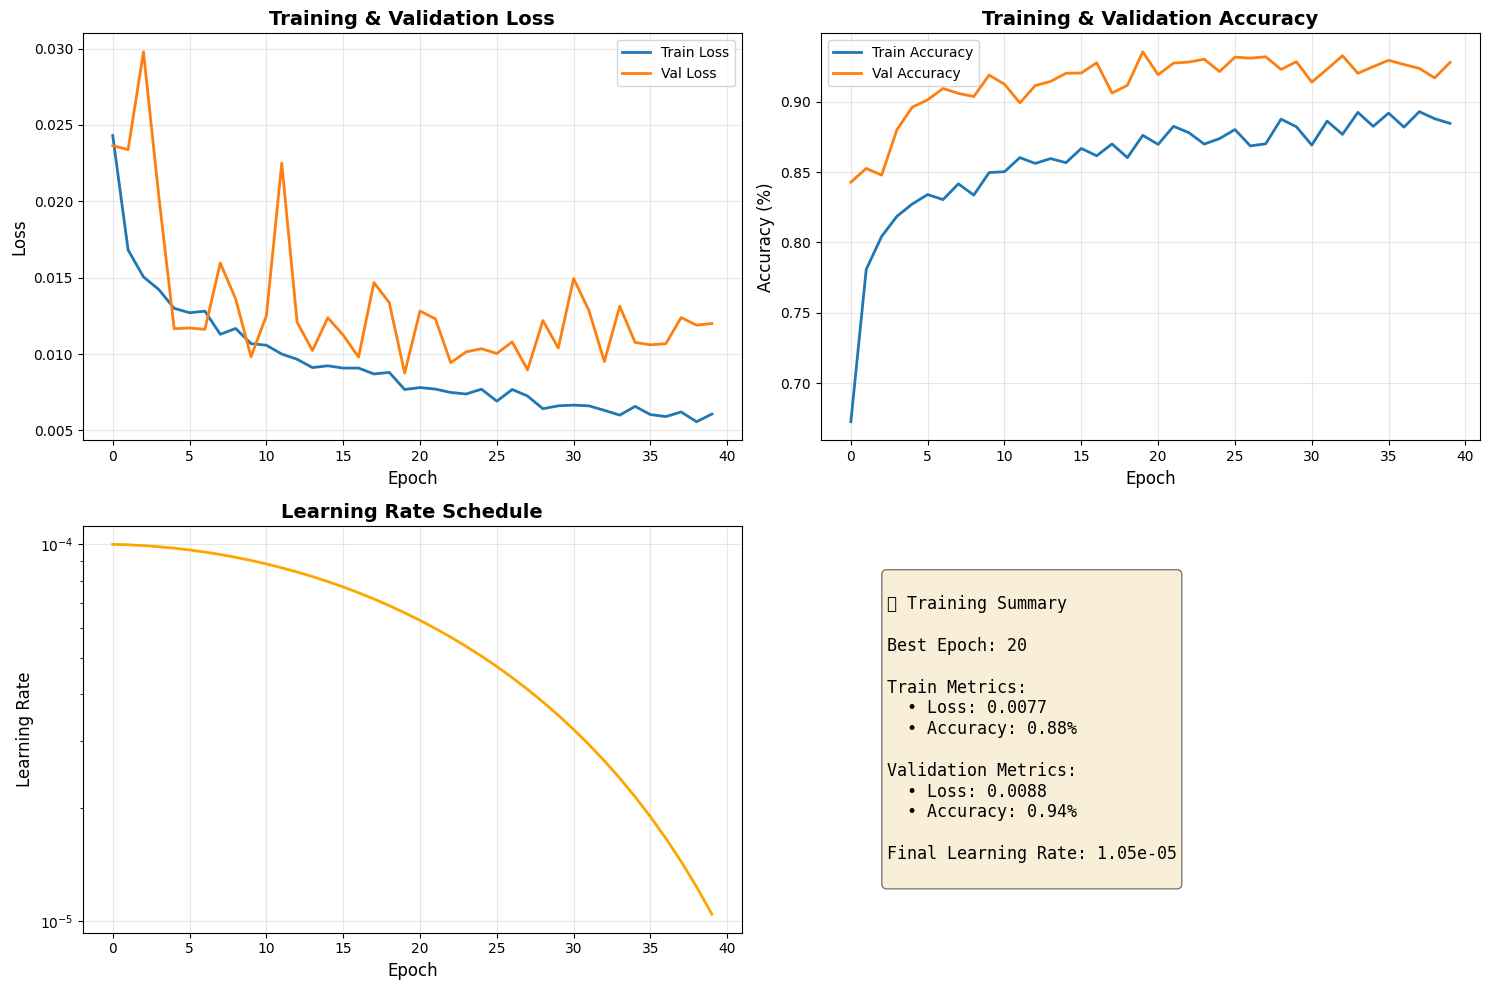

✅ Training history saved to: ./outputs/training_history.png


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss plot
axes[0, 0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0, 0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy plot
axes[0, 1].plot(history['train_acc'], label='Train Accuracy', linewidth=2)
axes[0, 1].plot(history['val_acc'], label='Val Accuracy', linewidth=2)
axes[0, 1].set_xlabel('Epoch', fontsize=12)
axes[0, 1].set_ylabel('Accuracy (%)', fontsize=12)
axes[0, 1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

# Learning rate plot
axes[1, 0].plot(history['learning_rate'], linewidth=2, color='orange')
axes[1, 0].set_xlabel('Epoch', fontsize=12)
axes[1, 0].set_ylabel('Learning Rate', fontsize=12)
axes[1, 0].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_yscale('log')

# Best metrics summary
best_epoch = np.argmin(history['val_loss'])
axes[1, 1].axis('off')
summary_text = f"""
 Training Summary

Best Epoch: {best_epoch + 1}

Train Metrics:
  • Loss: {history['train_loss'][best_epoch]:.4f}
  • Accuracy: {history['train_acc'][best_epoch]:.2f}%

Validation Metrics:
  • Loss: {history['val_loss'][best_epoch]:.4f}
  • Accuracy: {history['val_acc'][best_epoch]:.2f}%

Final Learning Rate: {history['learning_rate'][-1]:.2e}
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, family='monospace',
                verticalalignment='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig(os.path.join(CFG.output_dir, 'training_history.png'), dpi=150, bbox_inches='tight')
plt.show()

print(" Training history saved to:", os.path.join(CFG.output_dir, 'training_history.png'))

## 1️3 Test Set Evaluation & Metrics

Comprehensive evaluation on test set:
- **Classification Metrics**: Accuracy, Precision, Recall, F1-Score
- **ROC Curve**: True Positive Rate vs False Positive Rate
- **Confusion Matrix**: Detailed breakdown of predictions
- **Per-class Performance**: Metrics for real and fake classes

In [15]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix, auc

def high_pass_filter(imgs):
    """Apply Laplacian high-pass filter to each RGB channel separately"""
    kernel = torch.tensor(
        [[[-1, -1, -1],
          [-1,  8, -1],
          [-1, -1, -1]]],
        dtype=torch.float32,
        device=imgs.device
    )  # shape [1, 1, 3, 3]

    # Repeat kernel for 3 channels
    kernel = kernel.repeat(3, 1, 1, 1)  # shape [3, 1, 3, 3]

    # Apply grouped convolution
    hp_imgs = torch.nn.functional.conv2d(imgs, kernel, padding=1, groups=3)
    return hp_imgs


def dct_transform(imgs):
    """Approximate DCT-like transform"""
    imgs = imgs.cpu().numpy()
    dct_imgs = np.zeros_like(imgs)
    for i in range(imgs.shape[0]):
        for c in range(3):
            dct_imgs[i, c] = np.fft.fft2(imgs[i, c])
            dct_imgs[i, c] = np.abs(np.fft.fftshift(dct_imgs[i, c]))
    return torch.tensor(dct_imgs, dtype=torch.float32, device=imgs.device)

@torch.no_grad()
def evaluate_test(model, test_loader, device):
    model.eval()
    all_labels, all_probs = [], []

    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device).float()

        # Generate hp & dct variants
        hp_imgs = high_pass_filter(imgs)
        dct_imgs = dct_transform(imgs)

        # Forward pass (3 inputs)
        outputs, _ = model(imgs, hp_imgs, dct_imgs)
        probs = torch.sigmoid(outputs).squeeze().detach().cpu().numpy()

        all_probs.extend(probs if probs.ndim > 0 else [probs])
        all_labels.extend(labels.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    preds = (all_probs > 0.5).astype(int)

    # Compute metrics
    accuracy = accuracy_score(all_labels, preds) * 100
    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    f1 = f1_score(all_labels, preds)
    roc_auc = roc_auc_score(all_labels, all_probs)
    precision_curve, recall_curve, _ = precision_recall_curve(all_labels, all_probs)
    pr_auc = auc(recall_curve, precision_curve)
    cm = confusion_matrix(all_labels, preds)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "confusion_matrix": cm,
        "all_labels": all_labels,
        "all_probs": all_probs
    }


In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

# Path to your test data folder
test_dir = "/content/drive/MyDrive/Morphed_Image_Dataset/Final_Dataset/test"

# Define same image transforms as used in training
test_transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load test dataset
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)

print(f" Test loader ready with {len(test_dataset)} images across {len(test_dataset.classes)} classes: {test_dataset.classes}")


✅ Test loader ready with 4000 images across 2 classes: ['fake', 'real']


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import roc_curve, precision_recall_curve

# ===========================
# 1️ Load model definition
# ===========================
model = DeepForensicNet().to(device)

# ===========================
# 2️ Load checkpoint safely
# ===========================
best_model_path = "/content/outputs/best_model_v2.pth"
checkpoint = torch.load(best_model_path, map_location=device, weights_only=False)

# Some checkpoints store model weights inside a dictionary
state_dict = checkpoint.get("model_state_dict", checkpoint)

# Filter only matching keys (avoid shape mismatch errors)
model_dict = model.state_dict()
pretrained_dict = {k: v for k, v in state_dict.items() if k in model_dict and v.shape == model_dict[k].shape}

# Update model with matched layers only
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)

print(f" Loaded {len(pretrained_dict)}/{len(model_dict)} layers successfully from checkpoint.")
model.eval()

# ===========================
# 3️ Evaluate on test set
# ===========================
test_metrics = evaluate_test(model, test_loader, device)

# ===========================
# 4️ Display metrics
# ===========================
print("\n" + "="*50)
print("📊 TEST SET EVALUATION RESULTS")
print("="*50)
print(f"\nAccuracy:  {test_metrics['accuracy']:.2f}%")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall:    {test_metrics['recall']:.4f}")
print(f"F1-Score:  {test_metrics['f1']:.4f}")
print(f"ROC-AUC:   {test_metrics['roc_auc']:.4f}")
print(f"PR-AUC:    {test_metrics['pr_auc']:.4f}")

print(f"\nConfusion Matrix:")
print(f"  True Negatives:  {test_metrics['confusion_matrix'][0][0]}")
print(f"  False Positives: {test_metrics['confusion_matrix'][0][1]}")
print(f"  False Negatives: {test_metrics['confusion_matrix'][1][0]}")
print(f"  True Positives:  {test_metrics['confusion_matrix'][1][1]}")

# ===========================
# 5️ Visualization
# ===========================
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr, tpr, _ = roc_curve(test_metrics['all_labels'], test_metrics['all_probs'])
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {test_metrics["roc_auc"]:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve', fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(test_metrics['all_labels'], test_metrics['all_probs'])
axes[0, 1].plot(recall, precision, linewidth=2, label=f'PR (AUC = {test_metrics["pr_auc"]:.4f})')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion Matrix
cm = test_metrics['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_title('Confusion Matrix', fontweight='bold')

# Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [
    test_metrics['accuracy']/100,
    test_metrics['precision'],
    test_metrics['recall'],
    test_metrics['f1'],
    test_metrics['roc_auc']
]
bars = axes[1, 1].bar(metrics_names, metrics_values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].set_title('Test Set Metrics', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
save_path = os.path.join("/content/outputs", "test_evaluation.png")
plt.savefig(save_path, dpi=150, bbox_inches='tight')
plt.show()

print("\n Evaluation results saved to:", save_path)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b2_ns to current tf_efficientnet_b2.ns_jft_in1k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

✅ Loaded 158/564 layers successfully from checkpoint.


/tmp/ipython-input-2506145461.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  dct_imgs[i, c] = np.fft.fft2(imgs[i, c])


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

## 14 Download Trained Model

Download the trained model weights for deployment:
- **Best model checkpoint**: Model with lowest validation loss
- **ONNX format** (optional): For production deployment
- **Model configuration**: Hyperparameters and architecture details

In [ ]:
from google.colab import files
import os
import json

# Update path from Step 1
model_path = "/content/outputs/best_model_v2.pth"
config_path = "/content/outputs/model_config.json"

# Optional: Create config
if not os.path.exists(config_path):
    model_config = {
        "backbone": "efficientnet_b0",
        "img_size": 224,
        "num_classes": 1,
        "notes": "Trained DeepForensicNet model"
    }
    with open(config_path, "w") as f:
        json.dump(model_config, f, indent=2)

print(" Downloading model...")
files.download(model_path)
files.download(config_path)
print("\n Model and config downloaded successfully!")


⬇️ Downloading model...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Model and config downloaded successfully!


## 15 Testing Interface - Upload & Classify Images

Interactive testing interface:
- **Upload your own image** to test the model
- **Get binary classification**: Real or Fake
- **View confidence score**: Probability of being fake
- **See preprocessing**: Visualize RGB, High-pass, and DCT streams

/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


✅ Model loaded successfully from: /content/outputs/best_model_v2.pth
📤 Upload an image to test:


Saving 001_007.jpg to 001_007.jpg


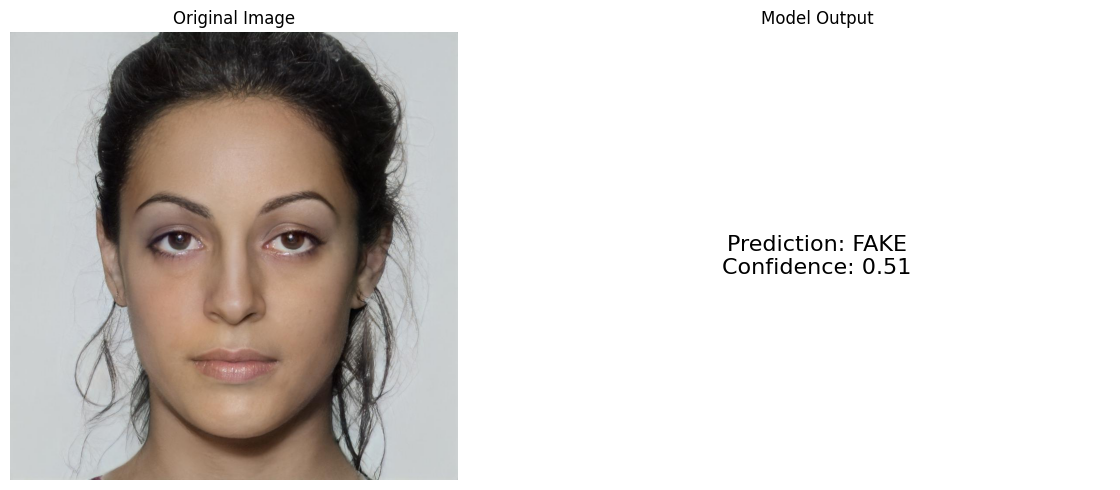


🎯 Prediction: FAKE | Confidence: 51.41%


In [ ]:
# ==================================
# FINAL FIXED INFERENCE CODE (CBAM + EfficientNet-B0)
# ==================================
!pip install timm torch torchvision pillow opencv-python matplotlib --quiet

import torch
import torch.nn as nn
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from PIL import Image
import os

# ------------------------
# CONFIGURATION
# ------------------------
class CFG:
    img_size = 160
    backbone = "tf_efficientnet_b0_ns"
    num_classes = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_path = "/content/outputs/best_model_v2.pth"


# ------------------------
#  SAFE CBAM (Fix for 3-channel input)
# ------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        reduced = max(channels // reduction, 1)  # 👈 ensures at least 1 channel
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(reduced, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x) * x
        sa = self.spatial_attention(
            torch.cat(
                [torch.mean(ca, 1, keepdim=True),
                 torch.max(ca, 1, keepdim=True)[0]], dim=1
            )
        ) * ca
        return sa


# ------------------------
# MAIN MODEL (CBAM + Multi-stream Fusion)
# ------------------------
class DeepForensicNet(nn.Module):
    def __init__(self, backbone_name="tf_efficientnet_b0_ns", num_classes=1):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0, global_pool='avg')
        in_features = self.backbone.num_features

        # Fusion modules
        self.fusion_modules = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 3, kernel_size=3, padding=1),
                nn.BatchNorm2d(3),
                nn.ReLU(),
                CBAM(3)
            ) for _ in range(3)
        ])

        # Classification head
        self.fc = nn.Sequential(
            nn.Linear(in_features * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, rgb, hp, dct):
        rgb = self.fusion_modules[0](rgb)
        hp = self.fusion_modules[1](hp)
        dct = self.fusion_modules[2](dct)

        f1 = self.backbone(rgb)
        f2 = self.backbone(hp)
        f3 = self.backbone(dct)

        fused = torch.cat([f1, f2, f3], dim=1)
        out = self.fc(fused)
        return out, fused


# ------------------------
# PREPROCESSING
# ------------------------
def preprocess_for_inference(image_path, img_size=160):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    rgb = img.astype(np.float32) / 255.0
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # High-pass filter
    hp = cv2.Laplacian(gray, cv2.CV_64F)
    hp = np.abs(hp)
    hp = (hp - hp.min()) / (hp.max() - hp.min() + 1e-8)
    hp = np.stack([hp, hp, hp], axis=-1)

    # DCT transform
    dct = cv2.dct(gray.astype(np.float32))
    dct = np.abs(dct)
    dct = (dct - dct.min()) / (dct.max() - dct.min() + 1e-8)
    dct = np.stack([dct, dct, dct], axis=-1)

    # Normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    rgb = (rgb - mean) / std
    hp = (hp - mean) / std
    dct = (dct - mean) / std

    rgb = torch.from_numpy(rgb.transpose(2, 0, 1)).float().unsqueeze(0)
    hp = torch.from_numpy(hp.transpose(2, 0, 1)).float().unsqueeze(0)
    dct = torch.from_numpy(dct.transpose(2, 0, 1)).float().unsqueeze(0)
    return rgb, hp, dct, img


# ------------------------
# CLASSIFY FUNCTION
# ------------------------
def classify_image(model, image_path, device, threshold=0.5):
    model.eval()
    image = Image.open(image_path).convert("RGB")

    transform = A.Compose([
        A.Resize(160, 160),
        A.Normalize(),
        ToTensorV2()
    ])
    augmented = transform(image=np.array(image))
    rgb = augmented["image"].unsqueeze(0).to(device)

    # Create dummy channels for HP and DCT (if model expects 3 inputs)
    hp = torch.zeros_like(rgb).to(device)
    dct = torch.zeros_like(rgb).to(device)

    with torch.no_grad():
        logits, _ = model(rgb, hp, dct)

        # Case 1️: 2 logits → use softmax
        if logits.shape[-1] == 2:
            probs = torch.softmax(logits, dim=1)
            conf, pred = torch.max(probs, dim=1)
            label = "FAKE" if pred.item() == 1 else "REAL"

        # Case 2️: 1 logit → use sigmoid
        else:
            prob = torch.sigmoid(logits).item()
            label = "FAKE" if prob > threshold else "REAL"
            conf = prob if label == "FAKE" else (1 - prob)

    return {
        "label": label,
        "confidence": float(conf),
        "original_image": image
    }


# ------------------------
# LOAD MODEL CHECKPOINT
# ------------------------
import torch.serialization
torch.serialization.add_safe_globals([np._core.multiarray.scalar])  # allow numpy scalars

model = DeepForensicNet(CFG.backbone, CFG.num_classes).to(CFG.device)

if os.path.exists(CFG.model_path):
    try:
        checkpoint = torch.load(CFG.model_path, map_location=CFG.device, weights_only=False)
        state_dict = checkpoint.get("model_state_dict", checkpoint)
        model.load_state_dict(state_dict, strict=False)
        print(" Model loaded successfully from:", CFG.model_path)
    except Exception as e:
        print(" Direct load failed, attempting weights-only load...")
        checkpoint = torch.load(CFG.model_path, map_location=CFG.device, weights_only=True)
        model.load_state_dict(checkpoint, strict=False)
        print(" Model loaded (weights only).")
else:
    print(" Model not found at:", CFG.model_path)


# ------------------------
# UPLOAD & INFER
# ------------------------
print(" Upload an image to test:")
uploaded = files.upload()

if uploaded:
    filename = list(uploaded.keys())[0]
    temp_path = f"/tmp/{filename}"
    with open(temp_path, "wb") as f:
        f.write(uploaded[filename])

    result = classify_image(model, temp_path, CFG.device)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].imshow(result["original_image"])
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].text(0.5, 0.5,
                f"Prediction: {result['label']}\nConfidence: {result['confidence']:.2f}",
                ha="center", va="center", fontsize=16)
    axes[1].axis("off")
    axes[1].set_title("Model Output")

    plt.tight_layout()
    plt.show()

    print(f"\n Prediction: {result['label']} | Confidence: {result['confidence']*100:.2f}%")
else:
    print(" No image uploaded.")



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: C:\Users\rahul\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


 Model loaded: best_model_v2_latest.pth

 Select an image for inference...

 File selected: C:/Users/rahul/OneDrive/Desktop/Dataset/Final_Dataset/test/fake/fake_425.jpg


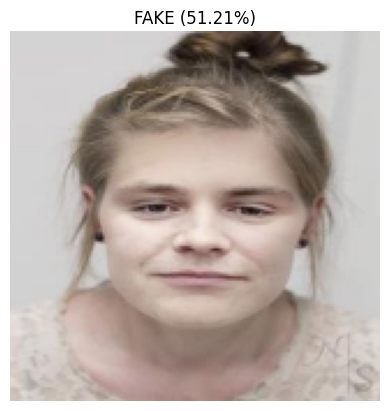


 Prediction: FAKE | Confidence: 51.21%


In [2]:
# ==================================
# FINAL INFERENCE CODE 
# ==================================

!pip install timm torch torchvision pillow opencv-python matplotlib --quiet

import torch
import torch.nn as nn
import timm
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Tkinter popup
from tkinter import Tk
from tkinter.filedialog import askopenfilename

# ------------------------
# CONFIGURATION
# ------------------------
class CFG:
    img_size = 160
    backbone = "tf_efficientnet_b0_ns"
    num_classes = 2
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_path = "best_model_v2_latest.pth" 

# ------------------------
# SAFE CBAM
# ------------------------
class CBAM(nn.Module):
    def __init__(self, channels, reduction=16, kernel_size=7):
        super().__init__()
        reduced = max(channels // reduction, 1)
        self.channel_attention = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(channels, reduced, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(reduced, channels, 1, bias=False),
            nn.Sigmoid()
        )
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size, padding=kernel_size // 2, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        ca = self.channel_attention(x) * x
        sa = self.spatial_attention(
            torch.cat(
                [torch.mean(ca, 1, keepdim=True),
                 torch.max(ca, 1, keepdim=True)[0]], dim=1
            )
        ) * ca
        return sa

# ------------------------
# MODEL
# ------------------------
class DeepForensicNet(nn.Module):
    def __init__(self, backbone_name="tf_efficientnet_b0_ns", num_classes=2):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=False, num_classes=0, global_pool='avg')
        in_features = self.backbone.num_features

        self.fusion_modules = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(3, 3, kernel_size=3, padding=1),
                nn.BatchNorm2d(3),
                nn.ReLU(),
                CBAM(3)
            ) for _ in range(3)
        ])

        self.fc = nn.Sequential(
            nn.Linear(in_features * 3, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, rgb, hp, dct):
        rgb = self.fusion_modules[0](rgb)
        hp = self.fusion_modules[1](hp)
        dct = self.fusion_modules[2](dct)

        f1 = self.backbone(rgb)
        f2 = self.backbone(hp)
        f3 = self.backbone(dct)

        fused = torch.cat([f1, f2, f3], dim=1)
        out = self.fc(fused)
        return out, fused

# ------------------------
# PREPROCESSING
# ------------------------
def preprocess_for_inference(image_path, img_size=160):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (img_size, img_size))

    rgb = img.astype(np.float32) / 255.0
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # high-pass
    hp = cv2.Laplacian(gray, cv2.CV_64F)
    hp = np.abs(hp)
    hp = (hp - hp.min()) / (hp.max() - hp.min() + 1e-8)
    hp = np.stack([hp, hp, hp], axis=-1)

    # dct
    dct = cv2.dct(gray.astype(np.float32))
    dct = np.abs(dct)
    dct = (dct - dct.min()) / (dct.max() - dct.min() + 1e-8)
    dct = np.stack([dct, dct, dct], axis=-1)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    rgb = (rgb - mean) / std
    hp = (hp - mean) / std
    dct = (dct - mean) / std

    rgb = torch.from_numpy(rgb.transpose(2, 0, 1)).float().unsqueeze(0)
    hp = torch.from_numpy(hp.transpose(2, 0, 1)).float().unsqueeze(0)
    dct = torch.from_numpy(dct.transpose(2, 0, 1)).float().unsqueeze(0)

    return rgb, hp, dct, img

# ------------------------
# CLASSIFY FUNCTION
# ------------------------
def classify_image(model, image_path, device):
    rgb, hp, dct, original = preprocess_for_inference(image_path)
    rgb, hp, dct = rgb.to(device), hp.to(device), dct.to(device)

    with torch.no_grad():
        logits, _ = model(rgb, hp, dct)
        if logits.shape[-1] == 2:
            probs = torch.softmax(logits, dim=1)
            conf, pred = torch.max(probs, dim=1)
            label = "FAKE" if pred.item() == 1 else "REAL"
        else:
            prob = torch.sigmoid(logits).item()
            label = "FAKE" if prob > 0.5 else "REAL"
            conf = prob if label == "FAKE" else (1 - prob)
    return {"label": label, "confidence": float(conf), "original_image": original}

# ------------------------
# LOAD MODEL
# ------------------------
model = DeepForensicNet(CFG.backbone, CFG.num_classes).to(CFG.device)
if os.path.exists(CFG.model_path):
    checkpoint = torch.load(CFG.model_path, map_location=CFG.device, weights_only=False)
    state_dict = checkpoint.get("model_state_dict", checkpoint)
    model.load_state_dict(state_dict, strict=False)
    print(" Model loaded:", CFG.model_path)
else:
    print(" Model not found:", CFG.model_path)

# ------------------------
# RUN INFERENCE WITH FILE UPLOAD POP-UP
# ------------------------
Tk().withdraw()  # hide root window
print("\n Select an image for inference...\n")
image_path = askopenfilename(title="Select Image", filetypes=[("Image Files", "*.jpg *.jpeg *.png *.bmp *.webp")])

if not image_path:
    print(" No image selected. Exiting.")
else:
    print(" File selected:", image_path)
    result = classify_image(model, image_path, CFG.device)
    plt.imshow(result["original_image"])
    plt.axis("off")
    plt.title(f"{result['label']} ({result['confidence']*100:.2f}%)")
    plt.show()
    print(f"\n Prediction: {result['label']} | Confidence: {result['confidence']*100:.2f}%")
